# AirBnB : Part 2, Model Selection ALL CITIES

In [ ]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns

import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,RandomizedLogisticRegression

from sklearn.svm import SVC
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.grid_search import GridSearchCV

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from xgboost import XGBClassifier
from utils import rstr,distance

import pickle

airBColor= '#ff5a5f'
airBColor2= '#008489'

### Add frequency reviews and distance to highlights

In [ ]:
#df = pd.read_csv('../../data/all_cities/dataset_for_modeling.csv')
features_RLR =  pickle.load(open('features_RLR.p', 'rb'))
features_Kbest_chi2=  pickle.load(open('features_Kbest_chi2.p', 'rb'))
features_Kbest_fclass=  pickle.load(open('features_Kbest_fclass.p', 'rb'))

df = pd.read_csv('../../data/all_cities/listing_cleansed_fillna.csv')
print df.host_id.isnull().sum()
df.drop('listings_per_host',axis=1,inplace=True)

df.loc[df['maximum_nights'] > 365, 'maximum_nights'] = 365

In [3]:
df.shape

(56879, 108)

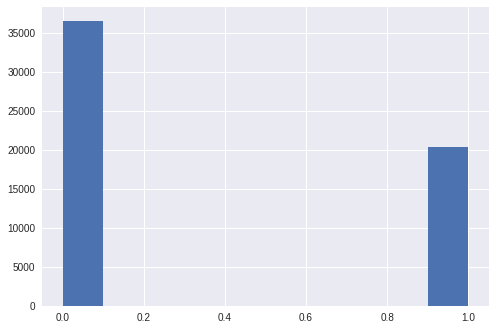

In [4]:
df.multihost.hist()

### Filter on listings with high reviews number

### Fill the missing data

In [5]:
df_missing_data = pd.DataFrame(df.isnull().sum()/len(df)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


## Linear Model and R-squared

In [6]:
TARGET_CLASSIFICATION ='multihost'
y = df[TARGET_CLASSIFICATION]

X = df.drop(TARGET_CLASSIFICATION,axis=1)

### Train test split

In [7]:
def balanced_subsample(y, size=None):

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

In [8]:
rebalanced_index = balanced_subsample(y)

In [9]:
X,y = X.loc[rebalanced_index],y.loc[rebalanced_index]

In [10]:
y.value_counts()

0    36494
1    20385
Name: multihost, dtype: int64

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2)
features = pd.Series(X.columns)
#scaler = MinMaxScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)


In [12]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=params, cv=n_folds, n_jobs=-1,scoring="recall")
    gs.fit(Xtrain, ytrain)
    
    return gs.best_estimator_

### Logistic Regression

In [13]:
lm = LogisticRegression(C=1e5)
lm.fit(X_train,y_train)
prediction = lm.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[6299 1000]
 [1533 2544]]
             precision    recall  f1-score   support

          0       0.80      0.86      0.83      7299
          1       0.72      0.62      0.67      4077

avg / total       0.77      0.78      0.77     11376



### Random Forest

In [14]:
clf = RandomForestClassifier()
params={}
best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
[[6492  807]
 [2014 2063]]
             precision    recall  f1-score   support

          0       0.76      0.89      0.82      7299
          1       0.72      0.51      0.59      4077

avg / total       0.75      0.75      0.74     11376



### XGB

In [15]:
params = {
    'max_depth':[9],
    'min_child_weight':[2],
    'learning_rate' :[0.1],
    'gamma':[0.0],
    'n_estimators':[100]
}

clf = XGBClassifier()

best_clf = cv_optimize(clf,params,X_train,y_train)

print(best_clf)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0, learning_rate=0.1, max_delta_step=0, max_depth=9,
       min_child_weight=2, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [16]:
prediction = best_clf.predict(X_test)
print confusion_matrix(y_test,prediction)
print classification_report(y_test,prediction)

[[6554  745]
 [1316 2761]]
             precision    recall  f1-score   support

          0       0.83      0.90      0.86      7299
          1       0.79      0.68      0.73      4077

avg / total       0.82      0.82      0.82     11376



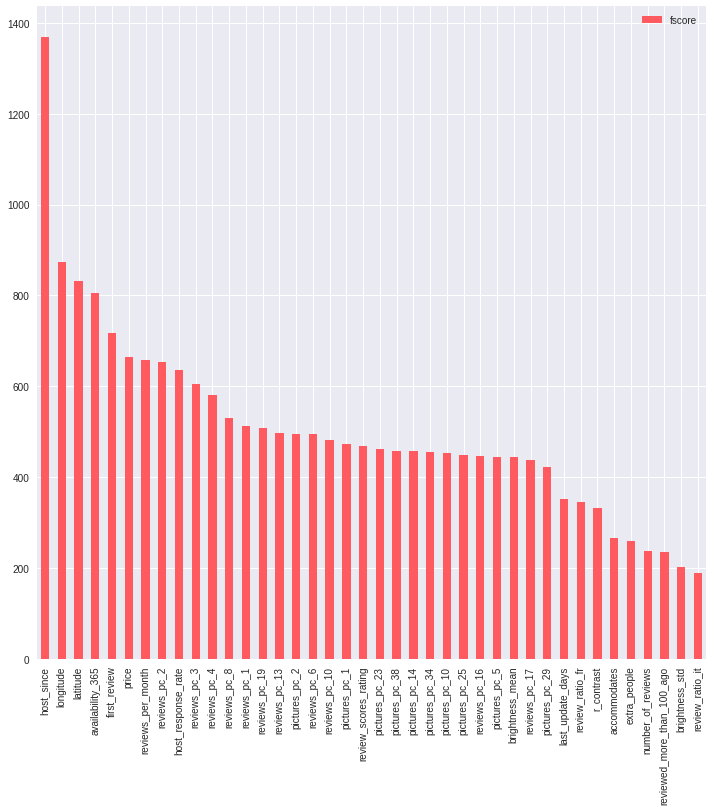

In [ ]:
features_weights = pd.DataFrame.from_dict(best_clf.booster().get_fscore(),orient="index")
features_weights.columns = ['fscore']

features_weights.sort_values(by='fscore',ascending=False).head(40).plot(kind='bar',title='',color=airBColor,figsize=(12,12))

### Keras

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

params = {
    'epochs':[500],
     'batch_size':[128]
}

def create_model():

    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_initializer='uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model


clf = KerasClassifier(build_fn=create_model, verbose=0)

best_clf = cv_optimize(clf,params,X_train.values,y_train.values)

print(best_clf)
prediction = best_clf.predict(X_test.values)
print confusion_matrix(y_test.values,prediction>.5)
print classification_report(y_test.values,prediction>.5)

Using TensorFlow backend.
Process PoolWorker-10:
Process PoolWorker-11:
Process PoolWorker-12:
Traceback (most recent call last):
  File "/home/ramon/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
    self.run()
  File "/home/ramon/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/ramon/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/ramon/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
  File "/home/ramon/anaconda2/lib/python2.7/multiprocessing/pool.py", line 102, in worker
    self.run()
  File "/home/ramon/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    task = get()
  File "/home/ramon/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwa